In [1]:
import xarray as xr
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.utils.data import DataLoader

In [2]:
ds = xr.open_dataset("../data.grib")
t2m_numpy = ds.t2m.to_numpy()
sp_numpy = ds.sp.to_numpy()
data = np.stack((t2m_numpy, sp_numpy), axis=-1)
data.shape

/home/kamil/Desktop/git/meteoapp-data/venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(
Ignoring index file '../data.grib.923a8.idx' older than GRIB file


(280, 25, 45, 2)

In [3]:
num_timestamps, num_latitudes, num_longitudes, num_features = data.shape
data = data.reshape(num_timestamps, -1, num_features)
data.shape

(280, 1125, 2)

In [4]:
data = data.reshape(-1, 5, num_latitudes * num_longitudes, num_features)
data.shape

(56, 5, 1125, 2)

In [5]:
def node_index(i, j, num_cols):
    return i * num_cols + j

edge_index = []
for i in range(num_latitudes):
    for j in range(num_longitudes):
        if i > 0:
            edge_index.append([node_index(i, j, num_longitudes), node_index(i - 1, j, num_longitudes)])
        if j > 0:
            edge_index.append([node_index(i, j, num_longitudes), node_index(i, j - 1, num_longitudes)])

grid_size = data.shape[1]
edge_index = torch.tensor(edge_index, dtype=torch.long).t()
edge_index.size()

torch.Size([2, 2180])

In [6]:
BATCH_SIZE = 5

class WeatherGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(WeatherGNN, self).__init__()
        self.gconv1 = GCNConv(input_dim, hidden_dim)
        self.gconv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv1x1 = nn.Conv2d(in_channels=BATCH_SIZE-1, out_channels=1, kernel_size=1)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, edge_index):
        x = self.gconv1(x, edge_index).relu()
        x = self.gconv2(x, edge_index).relu()
        x = self.conv1x1(x).relu()
        x = self.fc(x)
        return x

input_dim = num_features
hidden_dim = 4096
num_future_timestamps = 1  # future timestamps to predict
output_dim = num_features * num_future_timestamps
model = WeatherGNN(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
train_ratio = 0.7
num_samples = data.shape[0]
train_size = int(train_ratio * num_samples)
train_data, val_data = data[:train_size], data[train_size:]

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)
edge_index = edge_index.to(device)

In [8]:
num_epochs = 100
val_loss_list = []
train_loss_list = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        inputs = batch[:, :BATCH_SIZE-1, :, :]
        targets = batch[:, BATCH_SIZE-1:, :, :]
        inputs = inputs.to(device)
        targets = targets.to(device)
        output = model(inputs, edge_index)
        loss = criterion(output, targets) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # if (epoch+1) % 10 == 0:
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}\nTrain Loss: {avg_loss:.4f}")
    train_loss_list.append(avg_loss)
    
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            batch = batch.to(device)
            inputs = batch[:, :BATCH_SIZE-1, :, :]
            targets = batch[:, BATCH_SIZE-1:, :, :]
            output = model(inputs, edge_index)
            loss = criterion(output, targets)
            val_loss += loss.item()
       
    # if (epoch+1) % 10 == 0:
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Val Loss: {avg_val_loss:.4f}\n---------")
    val_loss_list.append(avg_val_loss)
    

Epoch 1/100
Train Loss: 2168455499.4872
Val Loss: 113824090.3529
---------
Epoch 2/100
Train Loss: 40960317.6410
Val Loss: 1475420.3529
---------
Epoch 3/100
Train Loss: 18347024.8718
Val Loss: 2593791.5882
---------
Epoch 4/100
Train Loss: 9423331.9231
Val Loss: 4120608.2353
---------
Epoch 5/100
Train Loss: 5244484.0513
Val Loss: 6947314.3529
---------
Epoch 6/100
Train Loss: 3291108.8974
Val Loss: 1981912.9118
---------
Epoch 7/100
Train Loss: 2079260.6026
Val Loss: 1571671.4412
---------
Epoch 8/100
Train Loss: 1605357.3590
Val Loss: 1767412.5588
---------
Epoch 9/100
Train Loss: 1399026.4231
Val Loss: 1471396.5000
---------
Epoch 10/100
Train Loss: 1247805.4231
Val Loss: 1375849.7941
---------
Epoch 11/100
Train Loss: 1199451.5769
Val Loss: 1364943.6471
---------
Epoch 12/100
Train Loss: 1190467.6667
Val Loss: 1360564.4706
---------
Epoch 13/100
Train Loss: 1194309.8974
Val Loss: 1360508.0294
---------
Epoch 14/100
Train Loss: 1186553.1026
Val Loss: 1360378.0294
---------
Epoch 15

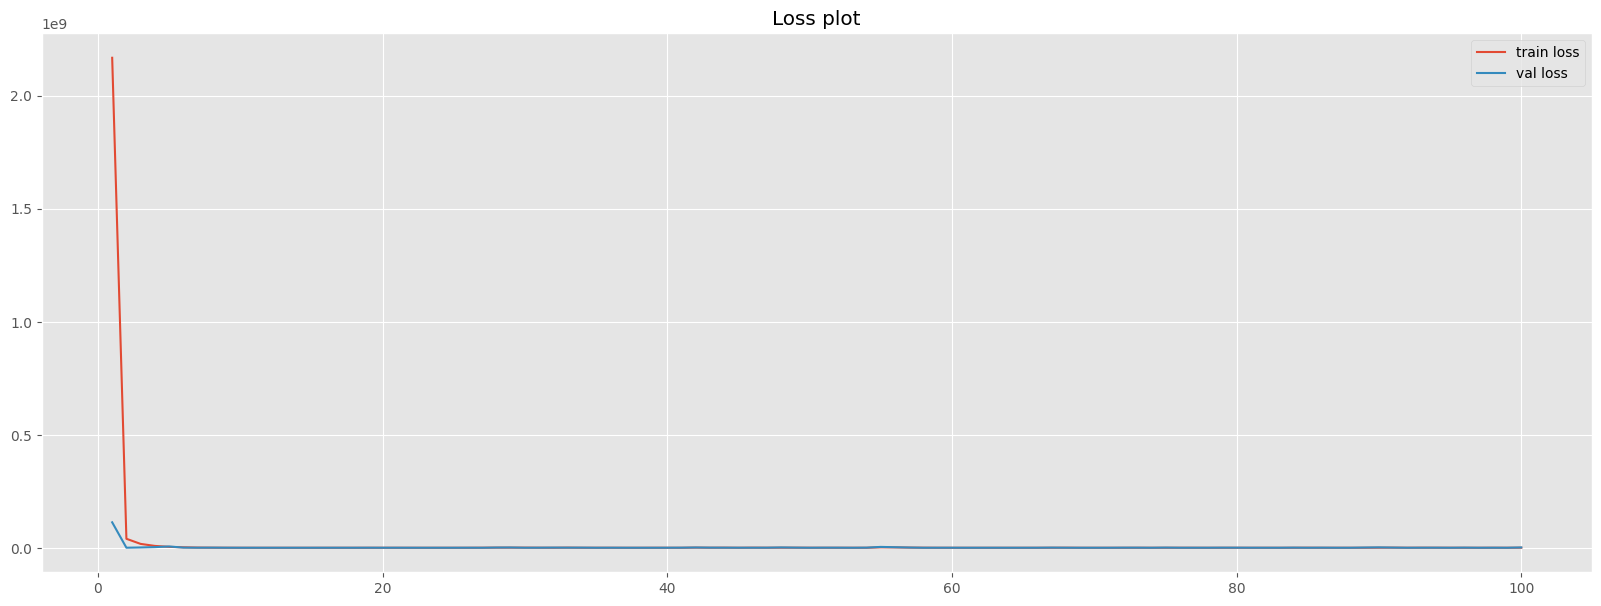

In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = np.arange(1, num_epochs+1)
plt.figure(figsize=(20,7))
plt.plot(x, train_loss_list, label = 'train loss')
plt.plot(x ,val_loss_list, label = 'val loss')
plt.title('Loss plot')
plt.legend()
plt.show()

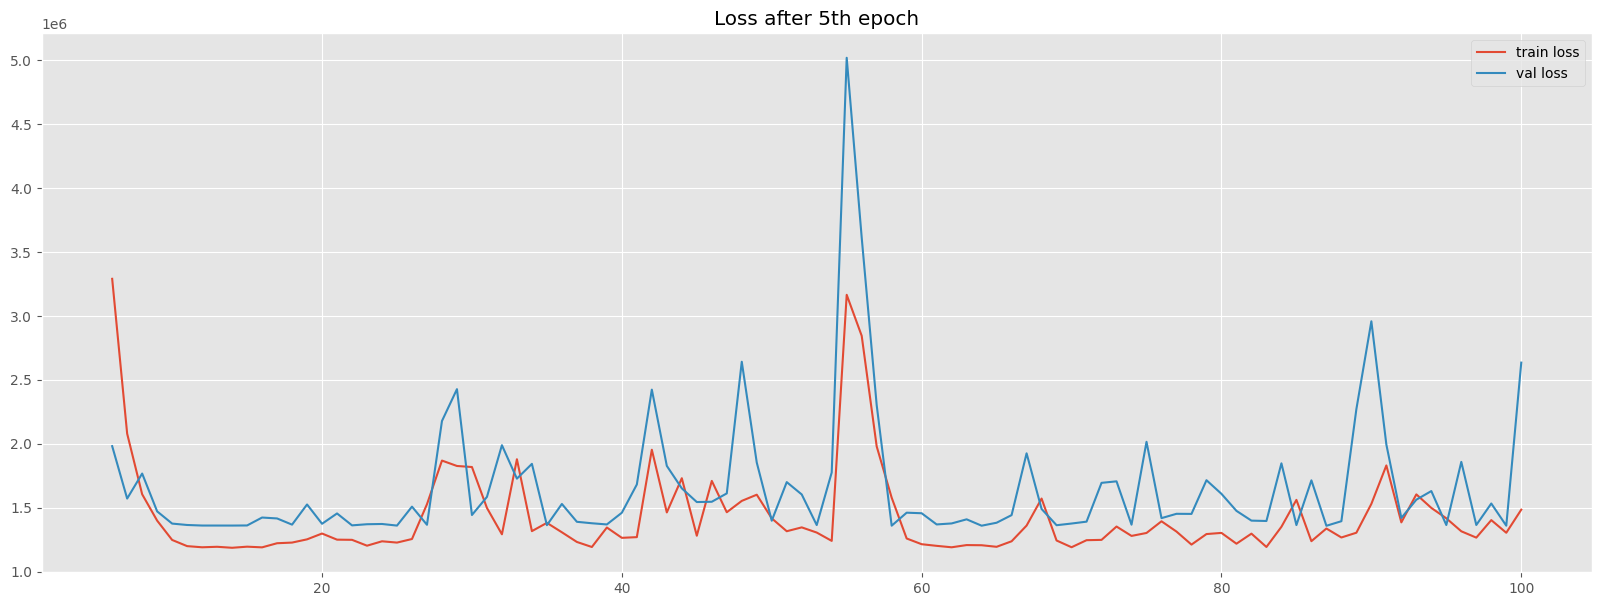

In [23]:
epoch = 5
plt.figure(figsize=(20,7))
plt.plot(x[epoch:], train_loss_list[epoch:], label = 'train loss')
plt.plot(x[epoch:] ,val_loss_list[epoch:], label = 'val loss')
plt.title(f'Loss after {epoch}th epoch')
plt.legend()
plt.show()

In [17]:
# for batch in val_loader:
#     break
# batch.to(device)
# predicted = model(batch, edge_index)
# predicted.shape
# predicted_grid = predicted.reshape(num_latitudes, num_longitudes, -1)
# temp_grid = predicted_grid[:,:,0] -  273.15
# plt.imshow(temp_grid.cpu().detach().numpy())
# plt.show()